In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from collections import Counter

In [14]:
ds_movies = pd.read_csv("../ml-latest-small/movies.csv")

CountVectorizer를 이용해서 영화 장르 정보를 원-핫 벡터로 변환합니다

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
genres = cv.fit_transform(ds_movies.genres)

# vocabulary에는 각 장르가 0~장르개수에 해당하는 index로 바뀌어서 저장됩니다.
cv.vocabulary_

{'adventure': 1,
 'animation': 2,
 'children': 3,
 'comedy': 4,
 'fantasy': 8,
 'romance': 19,
 'drama': 7,
 'action': 0,
 'crime': 5,
 'thriller': 21,
 'horror': 12,
 'mystery': 16,
 'sci': 20,
 'fi': 9,
 'war': 22,
 'musical': 15,
 'documentary': 6,
 'imax': 13,
 'western': 23,
 'film': 10,
 'noir': 18,
 'no': 17,
 'genres': 11,
 'listed': 14}

In [18]:
genres = pd.DataFrame(
    genres.toarray(),
    columns=list(sorted(cv.vocabulary_.keys(), key=lambda x: cv.vocabulary_[x]))
)
genres

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,fi,...,listed,musical,mystery,no,noir,romance,sci,thriller,war,western
0,0,1,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,1,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9738,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9739,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


그러면 이제 영화 정보를 바탕으로 각 영화간의 거리를 계산할 수 있습니다.

In [20]:
# 0번째 영화와 1번째 영화의 유클리디언 거리를 계산하기
a = genres.iloc[0, :]
b = genres.iloc[1, :]
np.linalg.norm(a-b)

1.4142135623730951

Scikit-Learn의 NearestNeighbors를 이용해서 장르 벡터를 기반으로 가장 유사한 영화를 찾아냅니다<br>
세부 인자를 지정하면 최적화 알고리즘이나 거리계산방식을 지정해줄 수 있습니다.<br>
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors

In [58]:
from sklearn.neighbors import NearestNeighbors

# n_neighbors: 가장 가까운 n개의 이웃을 찾도록 지정합니다.
nbrs = NearestNeighbors(n_neighbors=100).fit(genres)
nbrs

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                 radius=1.0)

In [59]:
distances, indexes = nbrs.kneighbors([a])
recommendations = ds_movies.loc[indexes[0], ["title"]]
recommendations["distance"] = distances[0]
recommendations

,title,distance
3000,"Emperor's New Groove, The (2000)",0.000000
9430,Moana (2016),0.000000
7760,Asterix and the Vikings (Astérix et les Viking...,0.000000
1706,Antz (1998),0.000000
2809,"Adventures of Rocky and Bullwinkle, The (2000)",0.000000
...,...,...
5615,Addams Family Reunion (1998),1.414214
4558,"Triplets of Belleville, The (Les triplettes de...",1.414214
5342,Shark Tale (2004),1.414214
4208,"Last Unicorn, The (1982)",1.414214


장르가 유사한 100개의 영화를 찾았으니 여기에 평점 점보를 결합해서 평점이 높은 순으로 정렬해보겠습니다

In [60]:
ds_ratings = pd.read_csv("../ml-latest-small/ratings.csv")

# 영화별로 평점과 평점개수를 계산합니다
ratings_mean_count = ds_ratings.groupby("movieId").agg({"rating": ["mean", "count"]})
ratings_mean_count.columns = ["ratings_mean", "ratings_count"]
# 평점은 소수점 1자리에서 반올림해줍니다.
ratings_mean_count.ratings_mean = ratings_mean_count.ratings_mean.round(1)
ratings_mean_count

,ratings_mean,ratings_count
movieId,,
1,3.9,215
2,3.4,110
3,3.3,52
4,2.4,7
5,3.1,49
...,...,...
193581,4.0,1
193583,3.5,1
193585,3.5,1


In [62]:
# 기존 추천 데이터에 합쳐줍니다
recommendations = pd.merge(recommendations, ratings_mean_count, left_index=True, right_index=True, how="left")
# 거리순에 이은 평점, 평점수 순으로 정렬해줍니다.
recommendations.sort_values(["distance", "ratings_mean", "ratings_count"], ascending=[True, False, False], inplace=True)
recommendations

,title,distance,ratings_mean,ratings_count
3000,"Emperor's New Groove, The (2000)",0.000000,4.0,48.0
6948,"Tale of Despereaux, The (2008)",0.000000,4.0,1.0
3568,"Monsters, Inc. (2001)",0.000000,4.0,1.0
2355,Toy Story 2 (1999),0.000000,3.5,92.0
9430,Moana (2016),0.000000,NaN,NaN
...,...,...,...,...
4558,"Triplets of Belleville, The (Les triplettes de...",1.414214,2.5,14.0
4466,Freaky Friday (2003),1.414214,2.5,2.0
12,Balto (1995),1.414214,2.4,19.0
5342,Shark Tale (2004),1.414214,NaN,NaN


PCA로 장르 분포를 시각화해보겠습니다

In [64]:
from sklearn.decomposition import PCA

genre_decomposed = PCA(n_components=2).fit_transform(genres)
genre_decomposed.shape

(9742, 2)

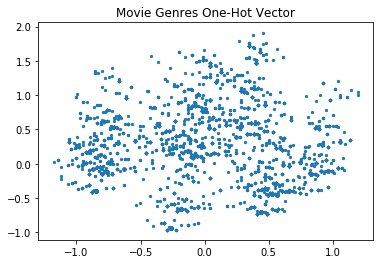

In [81]:
import matplotlib.pyplot as plt

plt.title("Movie Genres One-Hot Vector")
plt.scatter(genre_decomposed[:, 0], genre_decomposed[:, 1], 5)
plt.show()